In [69]:
import ipywidgets as widgets
import cv2
from matplotlib import pyplot as plt
from gtts import gTTS
from IPython.display import Audio

options_scene_category = ['Pre-trained Inceptionv3 - 365 Categories', 'Custom Model - 30 Categories']
options_use_gpt = ['True','False']

<h1> Main

In [70]:
dropdown_scene = widgets.Dropdown(options=options_scene_category, description = 'Select a model for Scene Classification: ', style={'description_width': '250px'})
dropdown_intergrated_approach = widgets.Dropdown(options=options_use_gpt, description = 'Improve Results with LLM?: ', style={'description_width': '175px'})
# Display the drop-down menu widget
display(dropdown_scene)
display(dropdown_intergrated_approach)

Dropdown(description='Select a model for Scene Classification: ', options=('Pre-trained Inceptionv3 - 365 Cate…

Dropdown(description='Improve Results with LLM?: ', options=('True', 'False'), style=DescriptionStyle(descript…

In [71]:
use_pretrained = (dropdown_scene.value == 'Pre-trained Inceptionv3 - 365 Categories')
use_llm = (dropdown_intergrated_approach.value == 'True')

In [72]:
if use_pretrained:
    import places365Inference as scene_model

else:
    import customModel as scene_model

import imageCaptioning as caption_model
if use_llm:
    import LLMInference

In [61]:
caption_threshold = 0.55
scene_threshold = 0.70

In [73]:
print(use_pretrained)

False


In [89]:
img_path = input("Pick an image")

In [90]:
#run inference
captions, caption_probs = caption_model.get_captions(img_path)
places, places_probs = scene_model.predict_category(img_path)

1/1 [==============================] - 0s 44ms/step


In [91]:
print(img_path)
print(captions,caption_probs)
print(places,places_probs)

LLMtest/00000009.jpg
['man in red shirt is standing on the grass', 'man in red shirt is sitting on bench', 'man in black shirt is sitting on bench'] [0.42 0.29 0.29]
['hospital_room', 'hospital', 'lake', 'hotel_room', 'river'] [1. 0. 0. 0. 0.]


In [92]:
is_caption_good = (caption_probs[0]>caption_threshold)
is_scene_good = (places_probs[0]>scene_threshold)


In [93]:
caption = ''
place = ''

In [94]:
#execute_caption_base
if is_caption_good and (caption_probs[0]>0.75 or places_probs[0]<0.8):
    place_idx = int(LLMInference.execute_caption_base(captions[0],places))
    caption = captions[0] 
    place = places[place_idx -1]
else:
    if is_scene_good:
        caption_idx = int(LLMInference.execute_scene_base(places[0],captions))
        place = places[0]
        caption = captions[caption_idx -1]
    else:
        if caption_probs[0] < 0.25:
            use_caption = (caption_probs[0]>places_probs[0])
            if use_caption:
                place_idx = int(LLMInference.execute_caption_base(captions[0],places))
                caption = captions[0] 
                place = places[place_idx - 1]
            else:
                caption_idx = int(LLMInference.execute_scene_base(places[0],captions))
                place = places[0]
                caption = captions[caption_idx -1 ]
        else:
            place_idx = int(LLMInference.execute_caption_base(captions[0],places))
            caption = captions[0] 
            place = places[place_idx -1]

Using Place as Base
Only one answer. Print corresponding order number of correct option:  which of the following descriptions match can be most suitable at hospital_room place: - 1. man in red shirt is standing on the grass, 2. man in red shirt is sitting on bench, 3. man in black shirt is sitting on bench. If none, return 1.
Man in black shirt is sitting on bench. 3


Place is : hospital_room and there, man in black shirt is sitting on bench


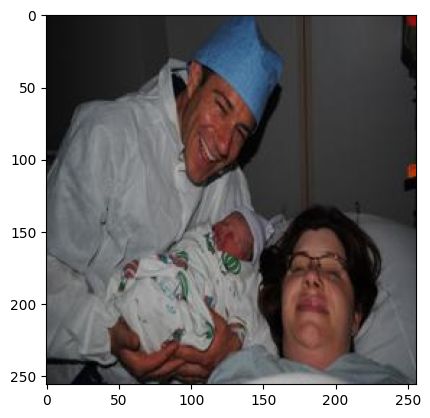

In [95]:
prompt = "Place is : {} and there, {}".format(place,caption)
print(prompt)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
tts = gTTS(text=prompt, lang='en')
tts.save('audio.mp3')

# load the audio file and play it within the notebook
Audio('audio.mp3', autoplay=False)